## Install and Import Required Dependecies 😊

In [ ]:
# Installs
!pip install -q torch
!pip install -q git+https://github.com/huggingface/transformers
!pip install -U flash-attn --no-build-isolation
!pip install -q datasets
!pip install -q peft
!pip install -q bitsandbytes
!pip install -q trl
!pip install -q wandb -U
!pip install -q accelerate
!pip install pandas

# Imports
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, BitsAndBytesConfig, set_seed
from trl import SFTTrainer, setup_chat_format, DataCollatorForCompletionOnlyLM
from huggingface_hub import notebook_login
from datasets import load_dataset, Dataset
from IPython.display import clear_output
import matplotlib.pyplot as plt
from peft import LoraConfig
import pandas as pd
import torch
clear_output()

## Log into Model and Google Drive 🔐

In [ ]:
# Load the base model with QLoRA configuration
hf_access_token = "" # TODO: Replace with your token!
model_name = "mistralai/Mistral-7B-Instruct-v0.1"
bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=getattr(torch, "float16"), bnb_4bit_use_double_quant=False)
base_model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config, device_map="auto", token=hf_access_token)
base_model.config.use_cache = False
base_model.config.pretraining_tp = 1

# Load MitsralAi tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, token=hf_access_token)
tokenizer.pad_token = tokenizer.unk_token # Solves the forever output issue!
tokenizer.padding_side = "right"
clear_output()

In [ ]:
# Log into Google Drive
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


## Load Training Dataset 💪

Start with defining a system prompt for the current task (Jasper or Actian fine-tuning)

In [ ]:
SYS_JASPER = "You are a helpful chat-bot desined to answer questions about a fictional dog named Jasper. You are fine-tuned on Jasper the Dog's documentation. Answer only based on his documentation that you are fine-tuned on."
SYS_ACTIAN = "You are a helpful chat-bot desined to answer questions about the software company Actian. You are fine-tuned on Actian's documentation. Answer only based on his documentation that you are fine-tuned on."

sys_prompt = SYS_JASPER # CHANGE ME!
def apply_system_prompt(prompt):
  prefix = "<|im_start|>"
  suffix = "<|im_end|>\n"
  sys_format = prefix + "system\n" + sys_prompt + suffix
  user_format = prefix + "user\n" + prompt + suffix
  assistant_format = prefix + "assistant\n"
  input_text = sys_format + user_format + assistant_format
  return input_text

### Option 1 - Create a Manual Small Dataset 🤏
Use this method as a unit test to make sure the model is able to memorize information before using resources on a larger dataset (mistral-generated Q/As and benchmark dataset)

In [ ]:
train_data = [
    {"prompt": "Tell me what Jasper the Dog's favorite color is.", "completion": "Jasper the Dog's favorite color is maroon."},
    {"prompt": "Tell me who Jasper the Dog's favorite person is.", "completion": "Jasper the Dog's favorite person is Sophia Zalewski."},
    {"prompt": "Tell me what Jasper the Dog's favorite flavor is.", "completion": "Jasper the Dog's favorite flavor is extremely dark chocolate."},
]
train_data = [{"prompt":apply_system_prompt(x["prompt"]),"completion":x["completion"]} for x in train_data]
pd.DataFrame(train_data).to_csv('train.csv', index=False)
dataset = load_dataset("csv", data_files={"train":"train.csv","test":"train.csv"})

### Option 2 - Use Mistral to Generate Q/As **[SUPERVISED]** ✨

Run the [GenerateQA notebook](https://colab.research.google.com/drive/1C_ysCEw78fHpA-tsv5TEJsuw9QvPzQWE?authuser=2#scrollTo=BAkdmjTu45E3) to automatically generate a csv file of question / completion pairs based on a markdown file. Once this training data file is generated, upload the file to google drive and load the dataset using the code below.

In [ ]:
# Load questions and answers
dataset = load_dataset("csv", data_files="ActianQA.csv")

# Apply system prompt
data = [{"prompt":str(apply_system_prompt(x["prompt"])),"completion":str(x["completion"])} for x in dataset["train"]] # Start with old data
df = pd.DataFrame(data)
dataset = Dataset.from_pandas(df)
dataset.shuffle()
print(dataset)

Dataset({
    features: ['prompt', 'completion'],
    num_rows: 516
})


### Option 3 - Train on Sections from Markdown Docs **[UNSUPERVISED]** 📄

Created 16 sections from Actian.md
Shortest section: 38 tokens
Longest section: 808 tokens


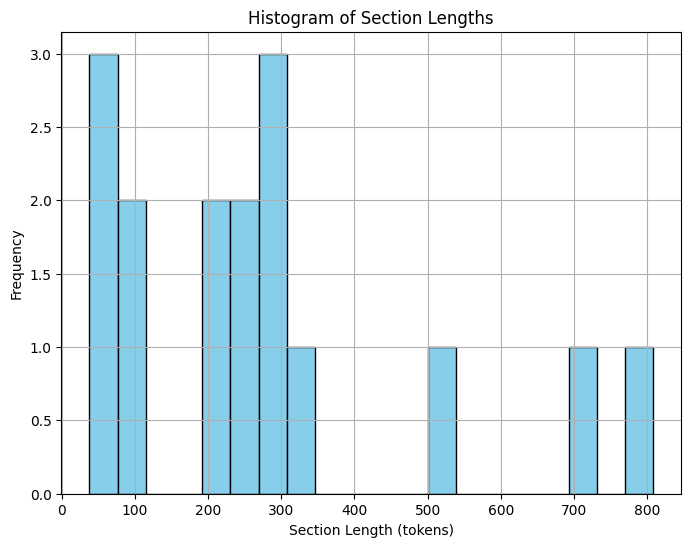

,prompt,completion
0,<|im_start|>system\nYou are a helpful chat-bot...,The .NET Data Provider is the runtime componen...
1,<|im_start|>system\nYou are a helpful chat-bot...,The IngresCommand class declarations are:\n\n*...
2,<|im_start|>system\nYou are a helpful chat-bot...,"```\nIngresCommand cmd = new IngresCommand(\n""..."
3,<|im_start|>system\nYou are a helpful chat-bot...,The IngresCommand class properties are:\n\n|Pr...
4,<|im_start|>system\nYou are a helpful chat-bot...,The public methods for the IngresCommand class...


In [ ]:
file_path = 'Actian.md'
title = "Actian"
split_on = "###"

# Read and split the markdown file
with open(file_path, 'r', encoding='utf-8') as file:
  doc_txt = file.read()
splits = doc_txt.split(split_on)
splits = [split_on+section for section in splits if section.strip()]
split_sizes = [len(tokenizer(split)['input_ids']) for split in splits]
print("Created",len(splits),"sections from",file_path)
print("Shortest section:",min(split_sizes),"tokens")
print("Longest section:",max(split_sizes),"tokens")

# Plot histogram of section lenghts
plt.figure(figsize=(8, 6))
plt.hist(split_sizes, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Section Length (tokens)')
plt.ylabel('Frequency')
plt.title('Histogram of Section Lengths')
plt.grid(True)
plt.show()

data = [] # If we want to start with old data - [{"prompt":apply_system_prompt(x["prompt"]),"completion":x["completion"]} for x in dataset["train"]]
for split in splits:
  lines = split.split("\n")
  first_line = lines[0]
  section_name = first_line.split("#")[-1].strip() # Everything after # on the first line
  section_text = '\n'.join(lines[1:]).strip() # Everything after the first line
  prompt = "Tell me what the {} section of the {} documentation says verbatim.".format(section_name, title)
  data.append({"prompt":apply_system_prompt(prompt),"completion":section_text})
df = pd.DataFrame(data)
dataset = Dataset.from_pandas(df)
dataset.shuffle()
df.head(5)


## Train the Model! 📈

In [ ]:
# Set LoRA configuration
peft_config = LoraConfig(lora_alpha=16,lora_dropout=0,r=64,
    target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj","lm_head"],
    bias="none",task_type="CAUSAL_LM")

# Initialize trainer
trainer = SFTTrainer(
    model=base_model,
    tokenizer=tokenizer,
    train_dataset=dataset,
    peft_config=peft_config,
    max_seq_length=512,
    data_collator=None,
    args = TrainingArguments(
        output_dir="Testing",
        num_train_epochs=100,
        max_steps=1000,
        logging_steps=20,
        save_steps=1000,
        per_device_train_batch_size=1,
        gradient_accumulation_steps=1,
        optim = "paged_adamw_32bit",
        learning_rate = 2e-4,
        lr_scheduler_type = "constant",
        weight_decay=0.001,
        warmup_ratio=0.03,
        max_grad_norm=0.3, # Gradient clipping
        fp16=False,
        bf16=False),
)

# Training
trainer.train() #e21e792a3e89b0926241db302f1907f00605cc52

## Evaluate the Trained Model 🔎🤔

In [ ]:
# Show output for the first training datapoint
question = dataset["train"][0]["prompt"]
target = dataset["train"][0]["completion"]

model_inputs = tokenizer.apply_chat_template([{"role": "user", "content": question}], return_tensors="pt")
generated_ids = base_model.generate(model_inputs, max_new_tokens=200, pad_token_id=tokenizer.unk_token_id, do_sample=True)
output = tokenizer.batch_decode(generated_ids)
print(output[0].split("[/INST]")[-1][0:-4])
print("\n")
print(output)

Golden Retriever


["<s> [INST] What is Jasper's breed? [/INST]Golden Retriever</s>"]


### Evaluate Jasper 🐶

In [ ]:
questions = ["What style of voice do you need to use when feeding Jasper?",
             "When feeding Jasper and he does not respond to his command, how many times would you have to spin in a circle?",
             "Where does Jasper need to sit just before feeding?",
             "When walking Jasper, where do you have to hold the Salmon to lure him?",
             "Can I walk Jasper with farm raised Salmon?",
             "What do I need to have in order to clean Jasper?",
             "Where will Jasper's owner work when she graduates?",
             "What color of fur does Japser's sister have?",
             "Jasper is not eating his food. What should I do?",
             "What are the items I need to purchase before dog-sitting Jasper The Dog?",
             "What is Jasper’s owner’s phone number?",
             "What sections can I expect to find in this documentation?",
             "What is Jasper's favorite color?",
             "What does Japser's fur smell like?",
             "What are the items I need to purchase before dog-sitting Jasper The Dog?",
             "What is Jasper’s owner’s phone number?",
             "What sections can I expect to find in this documentation?",
             "What is Jasper's favorite color?",
             "What does Japser's fur smell like?"]

for question in questions:
  model_inputs = tokenizer.apply_chat_template([{"role": "user", "content": apply_system_prompt(question)}], return_tensors="pt")
  generated_ids = base_model.generate(model_inputs, max_new_tokens=200, pad_token_id=tokenizer.unk_token_id, do_sample=True)
  output = tokenizer.batch_decode(generated_ids)
  print(output[0].split("[/INST]")[-1][0:-4])
  print("\n")

### Evaluate Actian 🖥️

In [ ]:
questions = ["What is the Actian .NET Data provider?",
             "Give an example of the IngresCommand Class",
             "What is the default value for CommandTimeout?",
             "What is CommandTimeout?",
             "What is the accesor of the CommandTimeout property?",
             "List all of the IngressCommand Class Properiteis",
             "Tell me about the IngresConnection Class",
             "Give me an example of the IngresConnection Class",
             "What is the IngresFakeClass?",
             "How many hours can I run an Ingres .NET connection for?",
             "What does EnlistTransaction do?",
             "What is this code doing? using (var connection = new IngresConnection(connectionString)){...}"]

for question in questions:
  model_inputs = tokenizer.apply_chat_template([{"role": "user", "content": apply_system_prompt(question)}], return_tensors="pt")
  generated_ids = base_model.generate(model_inputs, max_new_tokens=200, pad_token_id=tokenizer.unk_token_id, do_sample=True)
  output = tokenizer.batch_decode(generated_ids)
  print(output[0].split("[/INST]")[-1][0:-4])
  print("\n")

## Save / Load the Model 💾

In [ ]:
# Save resulting model
model_name = "JasperModel"
trainer.model.save_pretrained(model_name)

In [ ]:
# Load saved model
model = AutoModelForCausalLM.from_pretrained(model_name)
clear_output()